# Enzyme analysis

1. Convert the enzyme variant to amino acids based on the AAs and be warned about 1 vs 0 so need to check
2. Calculate concentration rather than yield (if yield is given then yield * mmol concentration)
3. Normalize to parent for each column (TTN, Yield)
4. Embeddings sequences
5. Convert to LevSeq format

In [15]:
! export CUDA_VISIBLE_DEVICES=1

In [16]:
import pandas as pd
import os
import torch 

# CUDA setup
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"
cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")
cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")

data_dir = '../data/'
df = pd.read_csv(os.path.join(data_dir, 'protein-evolution-database_V4.csv'))
df

,culture_collection_entry,enzyme_name_from_paper,Uniprot_ID(if applicable),comment,reaction_smiles,parent_DNA_sequence,parent_aminoacid_sequence,aminoacid_mutations_from_parent,variant_DNA_sequence,mutations_from_parent,...,TTN (if applicable),"selectivity(ee%),diastereo or chemo should be a separate smiles entry",alternative_product_SMILES,failed_substrates (if available),date published,first author,paper title,doi,SUBMITTED BY,raw data name
0,?,P411-L1,?,3a,O=C1OCCC1=[N+]=[N-].CNC1=CC=CC=C1>>O=C1OCC[C@@...,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,?,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,?,...,27.2,?,?,?,20211018,Zhen Liu,Dual-Function Enzyme Catalysis for Enantiosele...,https://doi.org/10.1038/s41557-021-00794-z,?,Asymmetric Carbene NH insertion 2021
1,?,P411-L2,?,3a,O=C1OCCC1=[N+]=[N-].CNC1=CC=CC=C1>>O=C1OCC[C@@...,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,T327V,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,GTG,...,213,?,?,?,20211018,Zhen Liu,Dual-Function Enzyme Catalysis for Enantiosele...,https://doi.org/10.1038/s41557-021-00794-z,?,Asymmetric Carbene NH insertion 2021
2,?,P411-L3,?,3a,O=C1OCCC1=[N+]=[N-].CNC1=CC=CC=C1>>O=C1OCC[C@@...,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,T327V_Q437L,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,GTG-CTT,...,288,?,?,?,20211018,Zhen Liu,Dual-Function Enzyme Catalysis for Enantiosele...,https://doi.org/10.1038/s41557-021-00794-z,?,Asymmetric Carbene NH insertion 2021
3,?,P411-L4,?,3a,O=C1OCCC1=[N+]=[N-].CNC1=CC=CC=C1>>O=C1OCC[C@@...,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,T327V_S332A_Q437L,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,GTG-GCG-CTT,...,451,?,?,?,20211018,Zhen Liu,Dual-Function Enzyme Catalysis for Enantiosele...,https://doi.org/10.1038/s41557-021-00794-z,?,Asymmetric Carbene NH insertion 2021
4,?,P411-L5,?,3a,O=C1OCCC1=[N+]=[N-].CNC1=CC=CC=C1>>O=C1OCC[C@@...,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,A87P_T327V_S332A_Q437L,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,CCG-GTG-GCG-CTT,...,1480,?,?,?,20211018,Zhen Liu,Dual-Function Enzyme Catalysis for Enantiosele...,https://doi.org/10.1038/s41557-021-00794-z,?,Asymmetric Carbene NH insertion 2021
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1336,NaN,Rma-cyt-c-V75R_M100D_M103D,?,?,[BH3-]C1=[N+](C=CN1C)C.CC(C(OCC2=CC=CC=C2)=O)=...,ATGACTGAAAGCGGGACTGCTGCACAAGACCCGGAAGCACTGGCAG...,MTESGTAAQDPEALAAEIGPVKQVSLGEQIDAALAQQGEQLFNTYC...,V75R_M100D_M103D,?,?,...,4200,84%,?,?,20171207,S. B. Jennifer Kan,Genetically programmed chiral organoborane syn...,doi:10.1038/nature24996,?,NaN
1337,NaN,Rma-cyt-c-V75R_M100D_M103F,?,?,[BH3-]C1=[N+](C=CN1C)C.O=C(OCC)C(C(F)(F)F)=[N+...,ATGACTGAAAGCGGGACTGCTGCACAAGACCCGGAAGCACTGGCAG...,MTESGTAAQDPEALAAEIGPVKQVSLGEQIDAALAQQGEQLFNTYC...,V75R_M100D_M103F,?,?,...,1560,90%,?,?,20171207,S. B. Jennifer Kan,Genetically programmed chiral organoborane syn...,doi:10.1038/nature24996,?,NaN
1338,NaN,Rma-cyt-c-V75P_M99Y_M100D_T101A_M103F,?,?,[BH3-]C1=[N+](C=CN1C)C.O=C(OCC)C(C2=CC=CC=C2)=...,ATGACTGAAAGCGGGACTGCTGCACAAGACCCGGAAGCACTGGCAG...,MTESGTAAQDPEALAAEIGPVKQVSLGEQIDAALAQQGEQLFNTYC...,V75P_M99Y_M100D_T101A_M103F,?,?,...,340,88%,?,?,20171207,S. B. Jennifer Kan,Genetically programmed chiral organoborane syn...,doi:10.1038/nature24996,?,NaN
1339,NaN,Rma-cyt-c-V75P_M100D_Y71C_M89C_M99C,?,?,[BH3-]C1=[N+](C=CN1C)C.[N-]=[N+]=C(C2=CC=CC=C2...,ATGACTGAAAGCGGGACTGCTGCACAAGACCCGGAAGCACTGGCAG...,MTESGTAAQDPEALAAEIGPVKQVSLGEQIDAALAQQGEQLFNTYC...,V75P_M100D_Y71C_M89C_M99C,?,?,...,1010,92%,?,?,20171207,S. B. Jennifer Kan,Genetically programmed chiral organoborane syn...,doi:10.1038/nature24996,?,NaN


# Iterate through the parent amino acid sequence and make the variant sequence 

Since sometimes people use 0 index and sometimes 1 index, first check the parent AA sequnece has the correct AA on the LHS.

In [17]:
from sciutil import SciUtil

u = SciUtil()

def convert_to_variant(parent, aa_to_change, verbose=False):
    warn = []
    error = []
    variant = []
    #try:
    aa_to_change = aa_to_change.replace(' ', '').strip()
    variant = list(parent)
    parent = list(parent)
    sep = '_'
    # check what separator was used
    if '_' in aa_to_change:
        sep = '_'
    elif ',' in aa_to_change:
        sep = ','
    for aa in aa_to_change.split(sep):
        if 'FAD' not in aa:
            aa = aa.split('+')[0] # Remove any random domains... 
            try:
                parent_aa = aa[0]
                variant_aa = aa[-1]
                position = int(aa[1:-1])
                # Check the parent at the position is correct
                if position < len(parent):
                    if parent[position] == parent_aa and parent[position - 1] == parent_aa : # Can't distinguish... since they are the same!
                        if verbose:
                            u.warn_p(['Defaulting to 1 index since could not distinguish... warning to check sequence'])
                        variant[position + 1] = variant_aa
                        warn.append([aa, 'Warning: position 0 and 1 index had same AA used 1 index'])
                    elif parent[position] == parent_aa: # 0 index
                        variant[position] = variant_aa
                    elif parent[position - 1] == parent_aa: # 1 index
                        variant[position - 1] = variant_aa
                    else:
                        error.append([aa, 'Error in parent AA != AA in seq']) # Failed at this one we have an idea about where it was
                elif parent[position - 1] == parent_aa: # 1 index
                        variant[position - 1] = variant_aa
                else:
                    error.append([aa, 'Error in parent AA != AA in seq']) # Failed at this one we have an idea about where it was
            except Exception as e:
                error.append([aa, str(e)])
        else:
            u.warn_p(['FAD domain, manually check'])

    # except:
    #     error.append([parent, 'Error: Parent missing'])
    #     warn.append(['Parent was missing?'])
    return ''.join(variant), warn, error
    
# Check these are the same since this is what we need
assert convert_to_variant('MTAKEMPQPKTFGELKNLPLLNTD', 'A2K')[0] == 'MTKKEMPQPKTFGELKNLPLLNTD' # 0 indexed example
assert convert_to_variant('MATKEMPQPKTFGELKNLPLLNTD', 'A2K')[0] == 'MKTKEMPQPKTFGELKNLPLLNTD' # 1 indexed
assert len(convert_to_variant('MAAKEMPQPKTFGELKNLPLLNTD', 'A2K')[1]) > 0 # Should print an error too 

In [18]:
from tqdm import tqdm 
from Bio.Seq import translate
import re

aas = ['A', 'R', 'N', 'D', 'C', 'E', 'Q', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']

reg = f"^[{''.join(aas)}]*$"

parent_aa = []
variant_aa = []
errors, warnings = [], []
changed = 0

for parent, parent_nt, aa_to_change, variant_nt in tqdm(df[['parent_aminoacid_sequence', 'parent_DNA_sequence', 'aminoacid_mutations_from_parent', 'variant_DNA_sequence']].values):
    if not parent or not isinstance(parent, str) or len(parent) < 2:
        # Try converting the parent nt
        if not parent_nt or not isinstance(parent_nt, str) or len(parent_nt) < 2:
            parent = None
            errors.append(['Parent was not string?'])
            warnings.append(['Parent was not string?'])
            parent_aa.append(None)
            continue
        parent_nt = parent_nt.replace(' ', '')
        parent = translate(parent_nt)
    parent = parent.replace(' ', '')
    parent = parent.strip()
    # We're replace his tags... 
    parent = parent.replace('LEHHHHHH', '').replace('HHHHHH', '').replace('*', '')
    # Check if the parent has any odd AAs
    if not re.match(reg, parent):
        # Parent has strange seqs..
        for ai, a in enumerate(parent):
            if a not in aas:
                print(a, ai)
        errors.append(['Parent had a non-correct AA in it.. check for numbers!'])
        variant_aa.append(None)
        warnings.append(None)
        parent_aa.append(parent)
        continue
    aa_to_change = aa_to_change.strip()
    if aa_to_change != '?' and parent is not None:
        variant, warn, err = convert_to_variant(parent, aa_to_change)
        # Check if it got truncated 
        variant = variant.split('*')[0] # Truncate 
        variant_aa.append(variant)
        # if not re.match(reg, variant):
        #     # Parent has strange seqs..
        #     print('NO MATCH')
        #     break
        changed += 1
        if variant_aa == parent:
            print('Same?', aa_to_change)
        if len(warn) == 0: 
            warnings.append(None)
        else:
            warnings.append(warn)
        if len(err) == 0:
            errors.append(None)
        else:
            errors.append(err)
    else:
        variant_aa.append(None)
        errors.append(None)
        warnings.append(None)
    parent_aa.append(parent)


  0%|          | 0/1341 [00:00<?, ?it/s]

--------------------------------------------------------------------------------
                          FAD domain, manually check	                           
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                          FAD domain, manually check	                           
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                          FAD domain, manually check	                           
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                          FAD domain, manually check	                           
--------------------------------------------------------------------------------
----------------------------

/disk1/ariane/miniconda3/envs/etk/lib/python3.10/site-packages/Bio/Seq.py:2879: BiopythonWarning: Partial codon, len(sequence) not a multiple of three. Explicitly trim the sequence or add trailing N before translation. This may become an error in future.
  warnings.warn(
100%|██████████| 1341/1341 [00:00<00:00, 27116.51it/s]


In [19]:
df['parent_aa'] = parent_aa
df['variant_aa'] = variant_aa
df['errors'] = errors
df['warnings'] = warnings

# Print out the number of errors
err_df = df[~df['errors'].isna()]
err_df['first author'].value_counts()

Series([], Name: count, dtype: int64)

# Continue with people who had no errors...


In [20]:
! pip install enzymetk

# First clean and drop duplicates before we move across



In [21]:
# Do ESM embedding of the ones that look good!
import sys
sys.path.append('/disk1/ariane/vscode/enzyme-tk')
from enzymetk.embedprotein_esm_step import EmbedESM
from enzymetk.save_step import Save
import pandas as pd

df['id'] = [f'DEDB{i}' for i in range(0, len(df))]
df = df[df['errors'].isna()]
variant_df = df[~df['variant_aa'].isna()] # Remove any that didn't have variants
variant_df = variant_df.drop_duplicates(subset=['variant_aa']) # Remove any that didn't have variants

variant_df['variant_id'] = [f'VDEDB{i}' for i in range(0, len(variant_df))]
variant_df['variant_aa_nohis'] = [s.replace('LEHHHHHH', '').replace('HHHHHH', '').replace('*', '') for s in variant_df['variant_aa'].values]

# Hmmm there are too many duplicates (need to check if this is from 
id_col = 'variant_id'
seq_col = 'variant_aa_nohis'


embedding_df = (variant_df << (EmbedESM(id_col, seq_col, extraction_method='mean', tmp_dir='/disk1/ariane/vscode/DirectedEvolutionDB/analysis/tmpv2/') >> Save('output/variant_df_no_errors.pkl')))

--------------------------------------------------------------------------------
Running command	conda run -n enzymetk python /disk1/ariane/miniconda3/envs/etk/lib/python3.10/site-packages/enzymetk/esm-extract.py esm2_t36_3B_UR50D /disk1/ariane/vscode/DirectedEvolutionDB/analysis/tmpv2//input.fasta /disk1/ariane/vscode/DirectedEvolutionDB/analysis/tmpv2/ --include per_tok	
--------------------------------------------------------------------------------


KeyboardInterrupt: 

In [ ]:
df.to_csv('DF4.csv', index=False)
df.to_csv('DF4.csv', index=False)


In [30]:
parents = df.drop_duplicates(subset=['parent_aa', 'reaction_smiles'])
parents['substrate_smiles'] = [x.split('>')[0] for x in parents['reaction_smiles'].values]
parents = parents.drop_duplicates(subset=['parent_aa', 'substrate_smiles'])
parents.to_csv('DF4_parents.csv', index=False)

/tmp/ipykernel_2079311/754165511.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  parents['substrate_smiles'] = [x.split('>')[0] for x in parents['reaction_smiles'].values]


In [31]:
parents

,culture_collection_entry,enzyme_name_from_paper,Uniprot_ID(if applicable),comment,reaction_smiles,parent_DNA_sequence,parent_aminoacid_sequence,aminoacid_mutations_from_parent,variant_DNA_sequence,mutations_from_parent,...,paper title,doi,SUBMITTED BY,raw data name,parent_aa,variant_aa,errors,warnings,id,substrate_smiles
0,?,P411-L1,?,3a,O=C1OCCC1=[N+]=[N-].CNC1=CC=CC=C1>>O=C1OCC[C@@...,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,?,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,?,...,Dual-Function Enzyme Catalysis for Enantiosele...,https://doi.org/10.1038/s41557-021-00794-z,?,Asymmetric Carbene NH insertion 2021,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,None,None,None,DEDB0,O=C1OCCC1=[N+]=[N-].CNC1=CC=CC=C1
15,4978,P411-L7_FL,?,3b,O=C1OCCC1=[N+]=[N-].CCNC1=CC=CC=C1>>O=C1OCC[C@...,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,A87P_A264S_T327P_S332A_Q437L+FAD,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,CCG-AGT-CCG-GCG-CTT+FAD,...,Dual-Function Enzyme Catalysis for Enantiosele...,https://doi.org/10.1038/s41557-021-00794-z,?,Asymmetric Carbene NH insertion 2021,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,None,None,DEDB15,O=C1OCCC1=[N+]=[N-].CCNC1=CC=CC=C1
16,4978,P411-L7_FL,?,3c,O=C1OCCC1=[N+]=[N-].CNC1=C(C)C=CC=C1>>O=C1OCC[...,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,A87P_A264S_T327P_S332A_Q437L+FAD,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,CCG-AGT-CCG-GCG-CTT+FAD,...,Dual-Function Enzyme Catalysis for Enantiosele...,https://doi.org/10.1038/s41557-021-00794-z,?,Asymmetric Carbene NH insertion 2021,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,None,None,DEDB16,O=C1OCCC1=[N+]=[N-].CNC1=C(C)C=CC=C1
17,4978,P411-L7_FL,?,3d,O=C1OCCC1=[N+]=[N-].CNC1=CC=C(C)C=C1>>O=C1OCC[...,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,A87P_A264S_T327P_S332A_Q437L+FAD,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,CCG-AGT-CCG-GCG-CTT+FAD,...,Dual-Function Enzyme Catalysis for Enantiosele...,https://doi.org/10.1038/s41557-021-00794-z,?,Asymmetric Carbene NH insertion 2021,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,None,None,DEDB17,O=C1OCCC1=[N+]=[N-].CNC1=CC=C(C)C=C1
18,4978,P411-L7_FL,?,3e,O=C1OCCC1=[N+]=[N-].CNC1=CC=C(F)C=C1>>O=C1OCC[...,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,A87P_A264S_T327P_S332A_Q437L+FAD,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,CCG-AGT-CCG-GCG-CTT+FAD,...,Dual-Function Enzyme Catalysis for Enantiosele...,https://doi.org/10.1038/s41557-021-00794-z,?,Asymmetric Carbene NH insertion 2021,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,None,None,DEDB18,O=C1OCCC1=[N+]=[N-].CNC1=CC=C(F)C=C1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1334,?,Rma-cyt-c-V75R_M100D_M103T,?,?,[BH3-]C1=[N+](C=CN1C)C.CC(C(OC(C)C)=O)=[N+]=[N...,ATGACTGAAAGCGGGACTGCTGCACAAGACCCGGAAGCACTGGCAG...,MTESGTAAQDPEALAAEIGPVKQVSLGEQIDAALAQQGEQLFNTYC...,V75R_M100D_M103T,?,?,...,Genetically programmed chiral organoborane syn...,doi:10.1038/nature24996,?,NaN,MTESGTAAQDPEALAAEIGPVKQVSLGEQIDAALAQQGEQLFNTYC...,MTESGTAAQDPEALAAEIGPVKQVSLGEQIDAALAQQGEQLFNTYC...,None,"[[M100D, Warning: position 0 and 1 index had s...",DEDB1334,[BH3-]C1=[N+](C=CN1C)C.CC(C(OC(C)C)=O)=[N+]=[N-]
1335,?,Rma-cyt-c-V75R_M100D_M103T,?,?,[BH3-]C1=[N+](C=CN1C)C.CC(C(OCC2=CC=CC=C2)=O)=...,ATGACTGAAAGCGGGACTGCTGCACAAGACCCGGAAGCACTGGCAG...,MTESGTAAQDPEALAAEIGPVKQVSLGEQIDAALAQQGEQLFNTYC...,V75R_M100D_M103T,?,?,...,Genetically programmed chiral organoborane syn...,doi:10.1038/nature24996,?,NaN,MTESGTAAQDPEALAAEIGPVKQVSLGEQIDAALAQQGEQLFN

In [ ]:
variant_df[variant_df['embedding'].isna()]['first author'].value_counts()

Series([], Name: count, dtype: int64)

# Plot the embeddings as a PCA or TSNE

Colour by various things like author etc 

In [ ]:
len(embedding_df['paper title'].value_counts()), len(embedding_df['first author'].value_counts())

(36, 29)

In [ ]:
embedding_df.columns

Index(['culture_collection_entry', 'enzyme_name_from_paper',
       'Uniprot_ID(if applicable)', 'comment', 'reaction_smiles',
       'parent_DNA_sequence', 'parent_aminoacid_sequence',
       'aminoacid_mutations_from_parent', 'variant_DNA_sequence',
       'mutations_from_parent', 'cofactor', 'additive (if applicable)',
       'additive_CAS', 'enzyme_form', 'substrate_concentration',
       'activity_for_reaction_% (if applicable)', 'TTN (if applicable)',
       'selectivity(ee%),diastereo or chemo should be a separate smiles entry',
       'alternative_product_SMILES', 'failed_substrates (if available)',
       'date published ', 'first author', 'paper title', 'doi', 'SUBMITTED BY',
       'raw data name', 'parent_aa', 'variant_aa', 'errors', 'warnings', 'id',
       'variant_id', 'variant_aa_nohis', 'embedding'],
      dtype='object')

Text(0.5, 1.0, 'PCA of the ESM2 embedding on each variant')

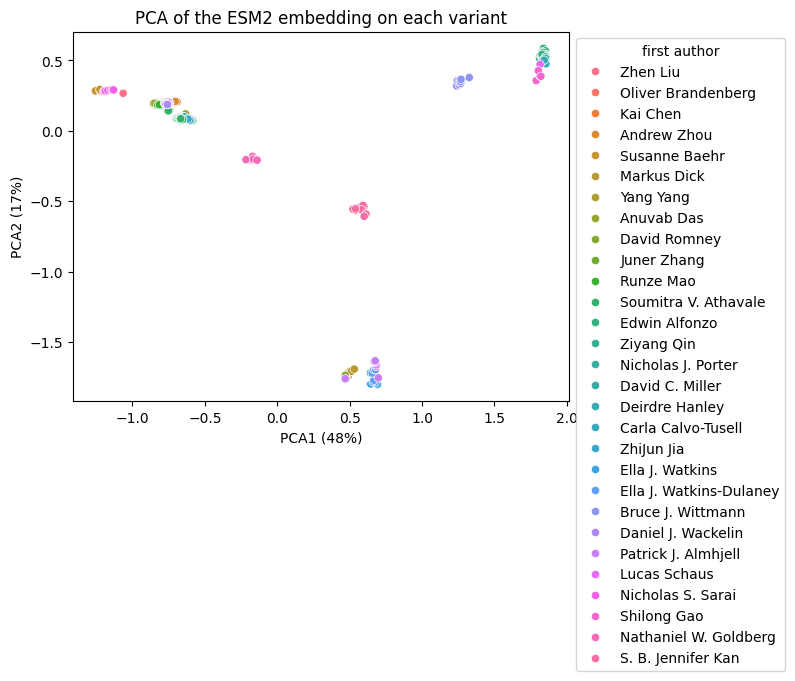

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

pca = PCA(n_components=2)
X = np.array([x for x in embedding_df['embedding'].values]).reshape((len(embedding_df), 2560))

pca_values = pca.fit_transform(X)
embedding_df['PCA1'] = pca_values[:, 0]
embedding_df['PCA2'] = pca_values[:, 1]

ax = sns.scatterplot(embedding_df, x='PCA1', y='PCA2', hue='first author')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xlabel(f'PCA1 ({int(pca.explained_variance_ratio_[0]*100)}%)')
plt.ylabel(f'PCA2 ({int(pca.explained_variance_ratio_[1]*100)}%)')
plt.title('PCA of the ESM2 embedding on each variant')

## Look at this compared to natural enzymes 

In [ ]:
protein_df = pd.read_pickle('/disk1/ariane/vscode/cec_degrader/manuscript/protein.pkl')
protein_df['first author'] = 'Natural'
protein_df.rename(columns={'esm_embedding': 'embedding'}, inplace=True)

all_rxns = pd.concat([embedding_df, protein_df])
pca = PCA(n_components=2)
X = np.array([x for x in all_rxns['embedding'].values]).reshape((len(all_rxns), len(all_rxns['embedding'].values[0])))
pca_values = pca.fit_transform(X)
all_rxns['PCA1'] = pca_values[:, 0]
all_rxns['PCA2'] = pca_values[:, 1]

ax = sns.scatterplot(all_rxns[all_rxns['first author'] == 'Natural'], x='PCA1', y='PCA2', color='grey', alpha=0.4)
ax = sns.scatterplot(all_rxns[all_rxns['first author'] != 'Natural'], x='PCA1', y='PCA2', hue='first author')

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.xlabel(f'PCA1 ({int(pca.explained_variance_ratio_[0]*100)}%)')
plt.ylabel(f'PCA2 ({int(pca.explained_variance_ratio_[1]*100)}%)')
plt.title('PCA of the ESM2 embedding on each variant')

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (261589,) + inhomogeneous part.

In [ ]:
all_rxns

,culture_collection_entry,enzyme_name_from_paper,Uniprot_ID(if applicable),comment,reaction_smiles,parent_DNA_sequence,parent_aminoacid_sequence,aminoacid_mutations_from_parent,variant_DNA_sequence,mutations_from_parent,...,EC number,Residue_0index,Residue_1index,active_site_residue_counts,Polarity,temperature,Length,Mass,active_embedding,esm_embedding
1,?,P411-L2,?,3a,O=C1OCCC1=[N+]=[N-].CNC1=CC=CC=C1>>O=C1OCC[C@@...,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,T327V,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,GTG,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,?,P411-L3,?,3a,O=C1OCCC1=[N+]=[N-].CNC1=CC=CC=C1>>O=C1OCC[C@@...,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,T327V_Q437L,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,GTG-CTT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,?,P411-L4,?,3a,O=C1OCCC1=[N+]=[N-].CNC1=CC=CC=C1>>O=C1OCC[C@@...,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,T327V_S332A_Q437L,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,GTG-GCG-CTT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,?,P411-L5,?,3a,O=C1OCCC1=[N+]=[N-].CNC1=CC=CC=C1>>O=C1OCC[C@@...,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,A87P_T327V_S332A_Q437L,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,CCG-GTG-GCG-CTT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,?,P411-L6,?,3a,O=C1OCCC1=[N+]=[N-].CNC1=CC=CC=C1>>O=C1OCC[C@@...,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,MTIKEMPQPKTFGELKNLPLLNTDKPVQALMKIADELGEIFKFEAP...,A87P_A264S_T327V_S332A_Q437L,ATGACAATTAAAGAAATGCCTCAGCCAAAAACGTTTGGAGAGCTTA...,CCG-AGT-GTG-GCG-CTT,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261249,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.-.-.-,NaN,NaN,0.0,0.0,27.0,428.0,46848.0,[],"[-0.026072642, 0.0077691125, -0.01714752, 0.00..."
261250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.1.1.-,NaN,NaN,0.0,0.0,30.0,226.0,25746.0,[],"[0.05820916, -0.0050475453, 0.031664737, 0.065..."
261251,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.13.11.-,NaN,NaN,0.0,0.0,30.0,208.0,23986.0,[],"[0.047606036, -0.01232071, 0.07216981, 0.01898..."
261252,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.4.-.-,NaN,NaN,0.0,0.0,30.0,318.0,36867.0,[],"[0.037483685, -0.05838441, -0.040710874, 0.078..."


# Convert to concentration from yield

If activity is reported, convert with the substrate concentration to the activity_for_reaction_% (if applicable) otherwise multiply TTN.

In [ ]:
def convert_to_yield(df, activity_col, substrate_conc_col):
    calc_yield = []
    errors = []
    for activity, substrate_mol in df[[activity_col, substrate_conc_col]].values:
        if substrate_mol:
            # Convert the substrate concentration to molar
            if 'mM' in substrate_mol:
                substrate_mol = float(substrate_mol.split('mM')[0].replace(' ', '')) * (10**(-3)) # divide by 1000
            elif 'nM' in substrate_mol:
                substrate_mol = float(substrate_mol.split('nM')[0].replace(' ', '')) * (10**(-9)) # divide by 10-9
            elif 'uM' in substrate_mol:
                substrate_mol = float(substrate_mol.split('uM')[0].replace(' ', '')) * (10**(-6)) # divide by 1000
            elif 'M' in substrate_mol:
                substrate_mol = float(substrate_mol.split('M').replace(' ', ''))
            else:
                substrate_mol = None
                calc_yield.append(None)
                errors.append(f'substrate mol had no concentrations, {substrate_mol}')
                continue
        else:
            calc_yield.append(None)
            errors.append(f'No mol: {substrate_mol}')
            continue
        if activity != '?':
            # If had `<` or `>` we just remove
            if '>' in activity or '<' in activity:
                activity = activity.replace('>', '')
                activity = activity.replace('<', '')
                errors.append('Had a > or <')
            elif activity == 'trace':
                activity = 0.0001
                errors.append('Trace activity, used 0.0001')
            else:
                errors.append(None)
            activity = float(activity)
            calc_yield.append(activity*substrate_mol)
        else:
            errors.append(f'No activity, {substrate_mol}')
            calc_yield.append(None)
    return calc_yield, errors

calc_yield, errors = convert_to_yield(df, 'activity_for_reaction_% (if applicable)', 'substrate_concentration')
df['yield_from_activity'] = calc_yield
df['errors_from_activity'] = errors

calc_yield, errors = convert_to_yield(df, 'TTN (if applicable)', 'substrate_concentration')
df['yield_from_TTN'] = calc_yield
df['TTN_errors'] = errors